In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.AutoFit.functions import *

from copy import copy


In [2]:
sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'

In [3]:
%matplotlib widget

## Measurement Data

The following measurement data are imported from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used in evaluation.

The transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 



In [8]:
### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc

# Emax, chw = get_chw_and_upperE(transdat6.E, 100.14)
# Emax, chw = get_chw_and_upperE(capdat1.E, 45.27)
# print(Emax)
# print(chw)
# energy_range_all = [150, 1000]
# energy_range_all = [201, 228]
energy_range_all = [202, 227]
# energy_range_all = [796, 814]
# energy_range_all = [197.6, 235]
data_Ebuff = 0

In [9]:
### 1mm capture data
capdat1 = sammy_functions.readlst(os.path.realpath("./data/yield_ta1b_unsmooth.dat"))
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                energy_range = energy_range_all,
                                energy_grid = capdat1.E.values, #np.sort(capdat1.E.values),
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )

capdat1 = capdat1.loc[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range)), :]

### 2mm capture data
capdat2 = sammy_functions.readlst(os.path.realpath("./data/yield_ta2_unsmooth.dat"))
expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                energy_range = energy_range_all,
                                energy_grid = np.sort(capdat2.E.values),
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat2 = capdat2.loc[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range)), :]

### 1mm Transmission data
transdat1 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-1mm.twenty"))
transdat1_covfile = os.path.realpath('./data/trans-Ta-1mm.idc')

chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)

exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,
                                energy_grid = np.sort(transdat1.E.values),
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1.loc[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range)), :]

### 3mm transmission data
transdat3 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-3mm.twenty"))
transdat3_covfile = os.path.realpath("./data/trans-Ta-3mm.idc")

exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,
                                energy_grid = np.sort(transdat3.E.values),
                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat3 = transdat3.loc[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range)), :]


### 6mm transmission data
transdat6 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-6mm.twenty"))
transdat6_covfile = os.path.realpath("./data/trans-Ta-6mm.idc")

exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,
                                energy_grid = np.sort(transdat6.E.values),
                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat6 = transdat6.loc[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range)), :]

### Not using 12mm measurement for evaluation - this is a validation measurement

# transdat12 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-12mm.dat")
# # transdat12_covfile = Need to generate from sys and stat covariances
# exptrans12 = Experimental_Model(title = "trans12",
#                                 reaction = "transmission",
#                                 energy_range = erange_all,

#                                 sammy_inputs = {
#                                     'alphanumeric'       :   ["BROADENING IS WANTED"],
#                                     'ResFunc'            :   "ORRES"
#                                         },

#                                 n = (0.067166, 0.0),  
#                                 FP = (35.185,0.0), 
#                                 burst = (8,0.0), 
#                                 temp = (294.2610, 0.0),

#                                 channel_widths={
#                                         "maxE": [270], 
#                                         "chw": [102.7],
#                                         "dchw": [0.8]
#                                         },

#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                                )

# transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


In [10]:
### plotting function

# plotting data & fits
# default fig size to output
fig_size = (8,6)


def plot_datafits(datasets, experiments, 
    fits=[], fits_chi2=[],
    priors=[], priors_chi2=[],
    true=[], true_chi2=[],
    true_pars = pd.DataFrame(), 
    prior_pars = pd.DataFrame(),
    fit_pars = pd.DataFrame(),
    title: str = '',
    show_spingroups: bool = True,
    fig_size : tuple = (8,6)
    ):

    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=fig_size, sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color='black', alpha=0.5, linewidth=1.0, markersize=4, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            if (len(fits_chi2) != 0):
                fit_label = f'fit {exp.title} ({fits_chi2[i]})'
            else:
                fit_label = f'fit {exp.title}'
            axes[iax].plot(fits[i].E, fits[i][model_key], color='red', zorder=1, lw=1.5, label=fit_label) # colors[i]
        
        if len(priors) != 0:
            if (len(priors_chi2) != 0):
                prior_label = f'prior {exp.title} ({priors_chi2[i]})'
            else:
                prior_label = f'prior {exp.title}'

            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color='orange', zorder=0, lw=1.5, label=prior_label)
        
        if len(true) != 0:
            if (len(true_chi2) != 0):
                true_label = f'JEFF {exp.title} ({true_chi2[i]})'
            else:
                true_label = f'JEFF {exp.title}'
            axes[iax].plot(true[i].E, true[i][model_key], '-', color='green', zorder=1, alpha=0.5, lw=1.5, label=true_label)


    # Set the y-axis limits with additional space for text and capture ymax before changing
    
    y_top_padding = 0.1 
    x_offset = 0.05

    ymax_values = [ax.get_ylim()[1] for ax in axes]  # Store original ymax values for each axis
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax + y_top_padding)

    font_size = 8
    y_text_shift = 0.01  # Adjust as needed, related to font size
    y_text_positions = [ymax_values[0], ymax_values[1]]

    # show vertical lines for energies
    
    # fits
    for index, res in fit_pars.iterrows():
        res_E = res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res_E, color='red', linestyle='--', linewidth=1.0, alpha=1.0)
        axes[1].axvline(x=res_E, color='red', linestyle='--', linewidth=1.0, alpha=1.0)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(int(res.J_ID),0)
            
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = res_E + x_offset
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                #ax.text(x_text_position, y_text_position, str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=8)

                ax.text(res_E, y_text_positions[i], str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=font_size)
                y_text_positions[i] -= y_text_shift


    # the same for theoretical positions
    for index, true_res in true_pars.iterrows():

        true_res_energy = true_res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)
        axes[1].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(true_res.J_ID,0)
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = true_res_energy
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                ax.text(x_text_position , y_text_position, str(sp_gr_txt), color='g', verticalalignment='bottom', fontsize=8)

    
    for index, res in prior_pars.iterrows():
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res.E, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
        axes[1].axvline(x=res.E, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    # set title
    fig.suptitle(title, fontsize=14)
    
    # additional info if present
    add_title = ''
    if (true_pars.shape[0]>0):
        add_title+=''+r'$N_{true}$ = '+str(true_pars.shape[0])
        
    if (len(true_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(true_chi2),3))

    if (prior_pars.shape[0]>0):
        add_title+=', '+r'$N_{prior}$ = '+str(prior_pars.shape[0])
    if (len(priors_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(priors_chi2),3))

    if (fit_pars.shape[0]>0):
        add_title+=', '+r'$N_{fit}$ = '+str(fit_pars.shape[0])
    if (len(fits_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(fits_chi2),3))
    
    # end additional info if present
    axes[0].set_title(add_title, fontsize=10)
    

    # ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        # ax.set_ylim([-0.1,1.1])
        ax.legend(fontsize='small', loc='lower right')

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

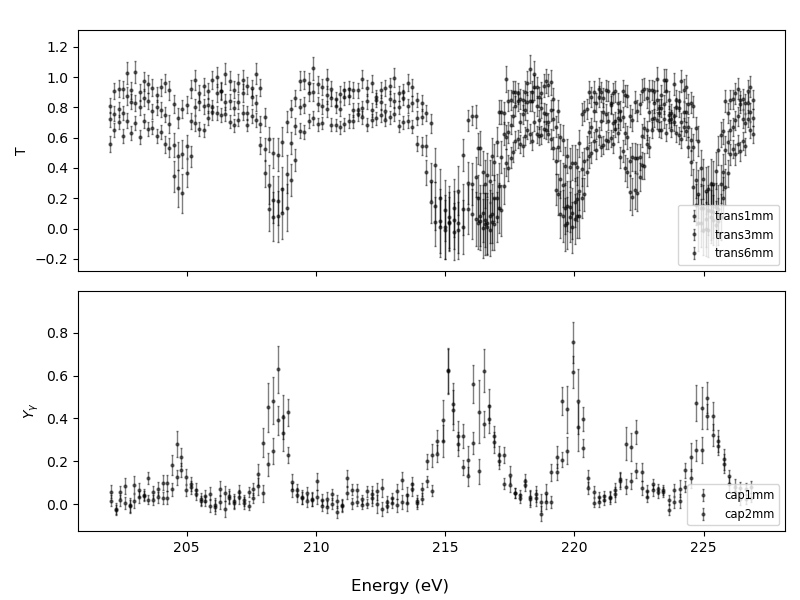

In [11]:
### setup in zipped lists 
datasets = [capdat1, capdat2, transdat1, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans3, exptrans6]

covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []

for data, exp in zip(datasets, experiments):
    filepath = os.path.realpath(f'./data/template_{exp.title}_edited')
    exp.template = os.path.realpath(filepath)


fig = plot_datafits(datasets, experiments, 
    # true_pars = true_ladder, 
    prior_pars = pd.DataFrame(),
)

fig.tight_layout()


## Fit from ENDF or JEFF

In [8]:
sammyRTO = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : False
                              })

matnum = 7328

In [9]:


endf_file = os.path.realpath("./data/n-073_Ta_181.endf")
endf_parameters = sammy_functions.get_endf_parameters(endf_file, matnum, sammyRTO)

endf_parameters = endf_parameters[(endf_parameters.E<np.max(energy_range_all)) & (endf_parameters.E>np.min(energy_range_all))]
endf_parameters["varyGn1"] = np.ones(len(endf_parameters))
endf_parameters["varyGg"] = np.ones(len(endf_parameters))*1
endf_parameters["varyE"] = np.ones(len(endf_parameters))

jeff_file = os.path.realpath("./data/73-Ta-181g.jeff33")
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

jeff_parameters = jeff_parameters[(jeff_parameters.E<np.max(energy_range_all)) & (jeff_parameters.E>np.min(energy_range_all))]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*0
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))


jendl_file = os.path.realpath("./data/n_073-Ta-181.dat")
jendl_parameters = sammy_functions.get_endf_parameters(jendl_file, 7328, sammyRTO)
jendl_parameters = jendl_parameters[(jendl_parameters.E<np.max(energy_range_all)) & (jendl_parameters.E>np.min(energy_range_all))]


tendl_file = os.path.realpath("./data/ta181.tendl")
tendl_parameters = sammy_functions.get_endf_parameters(tendl_file, 7328, sammyRTO)
tendl_parameters = tendl_parameters[(tendl_parameters.E<np.max(energy_range_all)) & (tendl_parameters.E>np.min(energy_range_all))]
tendl_parameters["varyGn1"] = np.ones(len(tendl_parameters))
tendl_parameters["varyGg"] = np.ones(len(tendl_parameters))*0
tendl_parameters["varyE"] = np.ones(len(tendl_parameters))


In [10]:

Ta_pair = Particle_Pair(isotope="Ta181",
                        formalism="XCT",
                        energy_range = energy_range_all,
                        ac=0.81271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=1)       # highest order l-wave to consider
# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615, #46.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=100)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, #35.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=100)


rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : False,
                              "sammy_runDIR": "sammy_runDIR_1"
                              })


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance= covariance_data, 
    
    max_steps = 25,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    maxF= 1.5,
    initial_parameter_uncertainty = 0.01
    )



In [11]:
rto.bayes

True

In [12]:

# external_resonance_ladder = generate_external_resonance_ladder([each[1] for each in Ta_pair.spin_groups.items()], energy_range_all, Ta_pair)
# jeff_parameters_wext, external_resonance_indices = concat_external_resonance_ladder(jeff_parameters, external_resonance_ladder)
# sammyINPyw.resonance_ladder = jeff_parameters_wext
# jeff_parameters_wext

In [13]:
sammyINPyw.resonance_ladder = jeff_parameters
sammyOUT_JEFF = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum', 'sum/ndat']
0    0.01 : [63.7279, 119.896, 73.9728, 171.182, 503.954, 932.7327, 3.6152]
1    0.02 : [57.6614, 124.014, 74.6704, 163.661, 466.215, 886.2218, 3.435]
2    0.04 : [56.8201, 124.164, 69.4013, 158.523, 456.684, 865.5924, 3.355]
3    0.08 : [56.4525, 126.295, 56.5916, 145.77, 432.978, 818.0871, 3.1709]
4    0.16 : [66.281, 140.527, 38.0125, 120.26, 390.024, 755.1045, 2.9268]
5    0.32 : [120.225, 207.647, 22.9856, 69.4164, 260.718, 680.992, 2.6395]
6    0.64 : [178.364, 285.471, 20.7345, 35.3622, 108.819, 628.7507, 2.437]
7    1.28 : [189.825, 301.597, 20.7419, 30.6213, 84.0916, 626.8768, 2.4298]
Chi2 improvement below threshold


In [14]:
sammyOUT_JEFF.par

,E,Gg,Gn1,Gn2,Gn3,varyE,varyGg,varyGn1,varyGn2,varyGn3,J_ID
0,204.67,64.9999,2.754,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,208.48,64.9999,9.422,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0


In [15]:
sammyOUT_JEFF.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,204.782452,64.9999,0.546874,1.0,0.0,1.0,1.0
1,208.410545,64.9999,0.675708,1.0,0.0,1.0,2.0


In [16]:
# sammyINPyw.resonance_ladder = endf_parameters
# sammyOUT_ENDF = sammy_functions.run_sammy_YW(sammyINPyw, rto)

In [17]:
# sammyINPyw.resonance_ladder = jendl_parameters
# sammyOUT_JENDL = sammy_functions.run_sammy_YW(sammyINPyw, rto)

In [18]:
sammyINPyw.resonance_ladder = tendl_parameters
sammyOUT_TENDL = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum', 'sum/ndat']
0    0.01 : [64.7477, 119.707, 77.0406, 173.735, 512.235, 947.4653, 3.6723]
1    0.02 : [58.6254, 124.171, 77.6088, 165.976, 474.075, 900.4562, 3.4901]
2    0.04 : [57.4372, 124.086, 71.8995, 160.54, 462.933, 876.8957, 3.3988]
3    0.08 : [56.3036, 125.689, 58.0576, 147.088, 435.978, 823.1162, 3.1904]
4    0.16 : [65.4286, 139.367, 38.5096, 121.02, 391.148, 755.4732, 2.9282]
5    0.32 : [117.462, 203.836, 23.1209, 70.8276, 268.025, 683.2715, 2.6483]
6    0.64 : [177.617, 284.384, 20.7335, 35.6074, 110.123, 628.4649, 2.4359]
7    1.28 : [189.38, 300.936, 20.7365, 30.7281, 84.721, 626.5016, 2.4283]
Chi2 improvement below threshold


In [19]:
# prior_lsts = lsts
print(sammyOUT_JEFF.chi2n, np.sum(sammyOUT_JEFF.chi2n))
print(sammyOUT_JEFF.chi2n_post, np.sum(sammyOUT_JEFF.chi2n_post))

print(sammyOUT_JEFF.chi2, np.sum(sammyOUT_JEFF.chi2))
print(sammyOUT_JEFF.chi2_post, np.sum(sammyOUT_JEFF.chi2_post))

[1.32766, 2.49784, 1.36987, 3.17003, 9.33248] 17.697879999999998
[3.95469, 6.28328, 0.383752, 0.56677, 1.55695] 12.745442
[63.7279, 119.896, 73.9728, 171.182, 503.954] 932.7327
[189.825, 301.597, 20.7226, 30.6056, 84.0755] 626.8257


In [20]:
# print(len(sammyOUT_TENDL.par[sammyOUT_TENDL.par.E>400]))
# print(len(sammyOUT_JEFF.par[sammyOUT_JEFF.par.E>500]))

In [21]:
4.14*1.74*1e-4/0.5

0.00144072

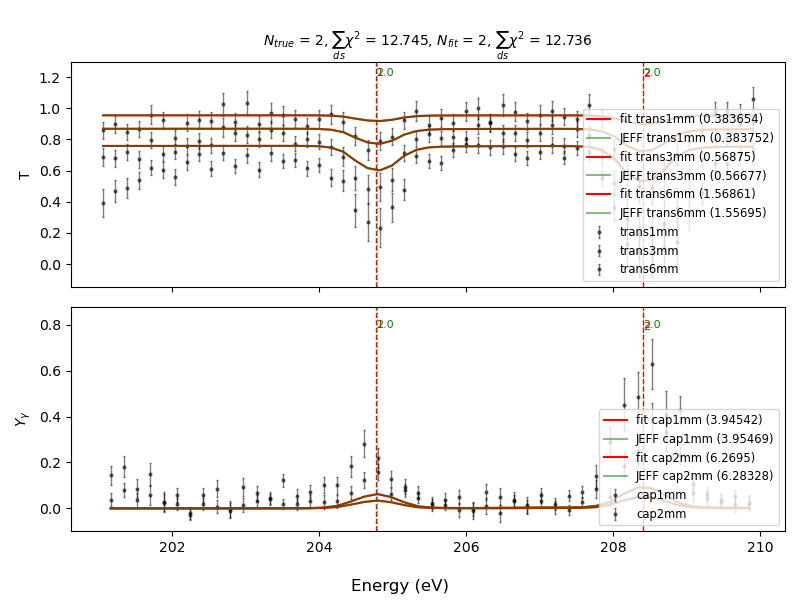

In [22]:
fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_TENDL.pw_post,
    fit_pars=sammyOUT_TENDL.par_post,
    fits_chi2=sammyOUT_TENDL.chi2n_post,
    # priors=sammyOUT_TENDL.pw,
    # prior_pars = sammyOUT_TENDL.par,
    # priors_chi2= sammyOUT_TENDL.chi2n,

    # priors=sammyOUT_JEFF.pw,
    # prior_pars = sammyOUT_JEFF.par,
    # priors_chi2= sammyOUT_JEFF.chi2n,
    true= sammyOUT_JEFF.pw_post,
    true_pars= sammyOUT_JEFF.par_post,
    true_chi2= sammyOUT_JEFF.chi2n_post,
)

fig.tight_layout()

## AutoFit

In [23]:
from ATARI.AutoFit import initial_FB_solve
importlib.reload(initial_FB_solve)

sammy_rto_fit = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


options = initial_FB_solve.InitialFBOPT(Gn_threshold=1e-2,
                       iterations=2,
                       max_steps = 50,
                       step_threshold=0.001,
                       LevMarV0=0.05,

                       fit_all_spin_groups=True,
                       fit_Gg = True,
                    #    spin_group_keys = ['3.0'],
                       
                       starting_Gn1_multiplier=10,
                       external_resonances=True)

autofit_initial = initial_FB_solve.InitialFB(options)

In [24]:
# terminating by small fudge but is not taking the proper step (taking 1 less)

In [25]:
initial_out = autofit_initial.fit(Ta_pair,
                            #    [200,230],
                           energy_range_all,
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit, 
                               external_resonance_ladder=pd.DataFrame()) #= jeff_parameters)


	FIT 1
Initial solve from 22 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum', 'sum/ndat']
0    0.05 : [222.45, 342.181, 22.6186, 24.9553, 26.8328, 639.0377, 2.4769]
1    0.075: [222.387, 342.056, 22.6111, 24.9312, 26.791, 638.7763, 2.4759]
2    0.113: [222.243, 341.772, 22.594, 24.8764, 26.6959, 638.1813, 2.4736]
3    0.169: [221.91, 341.115, 22.5545, 24.7495, 26.4754, 636.8044, 2.4682]
4    0.253: [221.112, 339.552, 22.46, 24.4458, 25.9473, 633.5171, 2.4555]
5    0.38 : [219.027, 335.53, 22.2138, 23.6576, 24.5913, 625.0197, 2.4226]
6    0.57 : [212.346, 323.094, 21.4436, 21.3535, 21.1562, 599.3933, 2.3232]
7    0.854: [184.349, 273.611, 18.7667, 16.8247, 22.745, 516.2964, 2.0011]
8    1.281: [125.09, 180.505, 15.7981, 23.5714, 58.7746, 403.7391, 1.5649]
9    1.922: [120.135, 176.404, 16.6043, 23.2814, 53.4089, 389.8336, 1.511]
10    2.0  : [118.506, 176.908, 16.8816, 21.0672, 43.9707, 377.3335, 1.462

In [26]:
len(initial_out.sammy_outs_fit_1)

2

In [27]:
start_ladder =  copy(initial_out.final_internal_resonances)
external_resonances = copy(initial_out.final_external_resonances)

start_ladder['varyGg'] = np.zeros(len(start_ladder))
start_ladder, external_resonance_indices = concat_external_resonance_ladder(start_ladder, external_resonances)

print(initial_out.final_external_resonances)
print(initial_out.final_internal_resonances)

          E             Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0  219.0030     126.981499    1.629314    0.0     1.0      1.0   1.0
1  191.9970     176.958372  388.083357    0.0     1.0      1.0   1.0
2  218.3031       7.719798  727.300839    0.0     1.0      1.0   2.0
3  192.6969  275788.791000   29.948293    0.0     1.0      1.0   2.0
             E           Gg       Gn1  varyE  varyGg  varyGn1  J_ID
4   200.736052    30.971985  0.885740    1.0     1.0      1.0   1.0
5   201.889731    11.671754  0.160482    1.0     1.0      1.0   1.0
6   204.155799  1467.890010  1.133220    1.0     1.0      1.0   1.0
7   204.738684    16.642177  1.757617    1.0     1.0      1.0   1.0
8   205.147152    98.060242  0.030874    1.0     1.0      1.0   1.0
9   208.393090   152.785370  2.604149    1.0     1.0      1.0   1.0
10  208.900335    52.588125  0.041420    1.0     1.0      1.0   1.0
11  201.283180    33.631960  0.365335    1.0     1.0      1.0   2.0
12  201.868865    34.531670  0.011995    1.

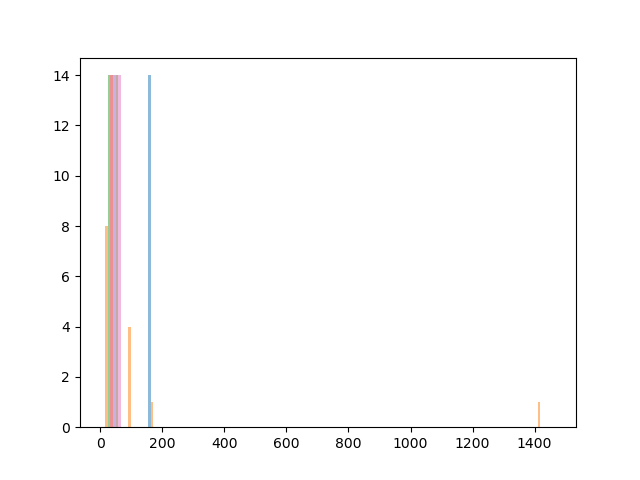

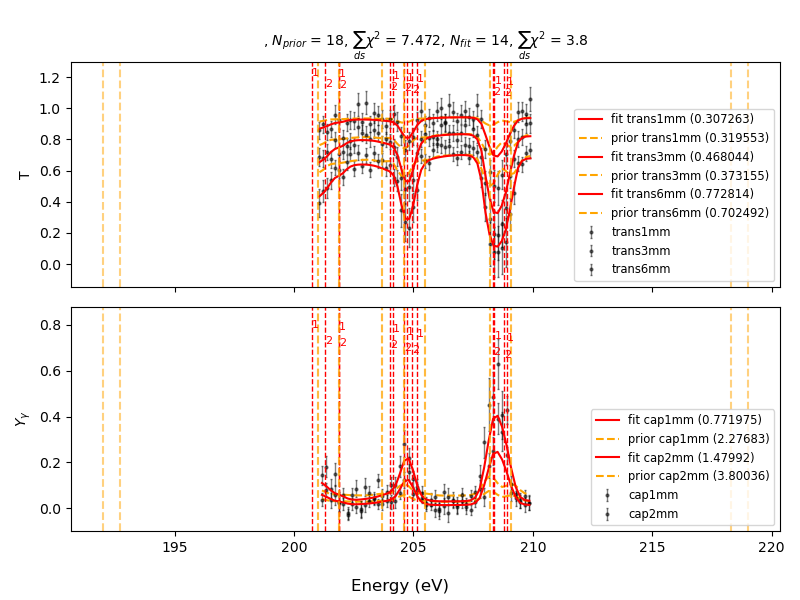

In [28]:
import matplotlib.pyplot as plt
sammyOUT_initialFB = initial_out.sammy_outs_fit_2[-1]
figure()
# _ = plt.hist(np.log10(sammyOUT_initialFB.par_post.Gn1), bins=20, label="Gn1")
_= plt.hist(initial_out.final_internal_resonances, bins=20, label="Gg", alpha=0.5)

fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_initialFB.pw_post,
    fit_pars=initial_out.final_internal_resonances,
    fits_chi2=sammyOUT_initialFB.chi2n_post,
    priors=sammyOUT_initialFB.pw,
    prior_pars = sammyOUT_initialFB.par,
    priors_chi2= sammyOUT_initialFB.chi2n
)

fig.tight_layout()

In [29]:
import importlib
from ATARI.AutoFit import chi2_eliminator_v2

elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 5,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.05
    )

# defining the elim_opts
# elim_opts = chi2_eliminator_v2.elim_OPTs(greedy_mode = True,
#                                          chi2_allowed = 5,
#                                          stop_at_chi2_thr = False,
#                                       fixed_resonances_df = external_resonances,
#                                       deep_fit_max_iter = 5,
#                                       deep_fit_step_thr = 0.1,
#                                       start_fudge_for_deep_stage = 0.05,
#                                       )

# elimi = chi2_eliminator_v2.eliminator_by_chi2(rto=sammy_rto_fit,
#                                             sammyINPyw = elim_sammyINPyw , 
#                                             options = elim_opts
#                             )

# history = elimi.eliminate(ladder_df=start_ladder)

In [30]:
initial_out.chi2_all[-1]


191.68959999999998

In [31]:
from ATARI.theory.resonance_statistics import wigner_LL, width_LL
from ATARI.theory.distributions import wigner_dist, porter_thomas_dist
from ATARI.utils.atario import expand_sammy_ladder_2_atari


wigner_distributions = {
                        3.0 : wigner_dist(beta=1, scale=Ta_pair.spin_groups[3.0]['<D>']),
                        4.0 : wigner_dist(beta=1, scale=Ta_pair.spin_groups[4.0]['<D>'])
                        }
gg2_distributions = {
                    3.0 : porter_thomas_dist(mean=Ta_pair.spin_groups[3.0]['<gg2>'], df=1000, trunc=0), #, trunc:float,
                    4.0 : porter_thomas_dist(mean=Ta_pair.spin_groups[4.0]['<gg2>'], df=1000, trunc=0)
                    }

gn2_distributions = {
                    3.0 : porter_thomas_dist(mean=Ta_pair.spin_groups[3.0]['<gn2>'], df=1, trunc=0), #, trunc:float,
                    4.0 : porter_thomas_dist(mean=Ta_pair.spin_groups[4.0]['<gn2>'], df=1, trunc=0)
                    }


In [32]:

# leading_obj_new = copy(ObjStart)
# leading_ladder_new = copy(start_ladder)

# print(f"Starting objective value: {leading_obj_new}")
# while True:

#     leading_obj_old = leading_obj_new
#     leading_ladder_old = leading_ladder_new

#     print(f"Prior eliminating from {len(leading_ladder_old)}")
#     for i in leading_ladder_old.index:
#         temp_internal = leading_ladder_old.drop([i])

#         LL_bypar, LL_bypar_bysg = get_LL_by_parameter(temp_internal, Ta_pair.spin_groups)

#         temp_ladder, _ = concat_external_resonance_ladder(temp_internal, external_ladder)
#         rto.bayes = False
#         elim_sammyINPyw.resonance_ladder = temp_ladder
#         samout_temp = sammy_functions.run_sammy_YW(elim_sammyINPyw, rto)
        
#         ObjTemp = np.sum(samout_temp.chi2)-LL_bypar[0] #np.sum(LL_bypar)
#         # dObj = ObjTemp - leading_obj_o

#         if ObjTemp < leading_obj_old:
#             leading_obj_new = ObjTemp
#             leading_ladder_new = temp_internal

#     print(f"Complete with new object value: {leading_obj_new}")
#     if leading_obj_old<=leading_obj_new:
#         break
    

In [70]:
def vals_to_obj(vals):
    return np.sum([vals[i] for i in [0,1,3]])

def get_parprob_vals(full_ladder, ext_ind):
    int_lad, ext_lad = separate_external_resonance_ladder(full_ladder, ext_ind)
    LL_bypar, _ = get_LL_by_parameter(expand_sammy_ladder_2_atari(Ta_pair, int_lad), Ta_pair.spin_groups)
    return list(-2*LL_bypar)


# def find_leading_model_for_next_level(leading_ladder_current, external_ladder_current, fit=False):

#     leading_vals = [1e10,1e10,1e10,1e10]
#     # assert(vals_to_obj(leading_vals) > )
#     leading_ladder = leading_ladder_current
#     leading_external = external_ladder_current
    
#     for i in leading_ladder_current.index:

#         temp_internal = leading_ladder_current.drop([i])
#         temp_ladder, ext_ind = concat_external_resonance_ladder(temp_internal, leading_external)
#         rto.bayes = fit
#         sammyINPyw.resonance_ladder = temp_ladder
#         samout_temp = sammy_functions.run_sammy_YW(sammyINPyw, rto)

#         if fit:
#             temp_internal, temp_external = separate_external_resonance_ladder(samout_temp.par_post, ext_ind)
#             chi2 = np.sum(samout_temp.chi2_post)
#         else:
#             temp_internal, temp_external = separate_external_resonance_ladder(samout_temp.par, ext_ind)
#             chi2 = np.sum(samout_temp.chi2)

#         LL_bypar, LL_bypar_bysg = get_LL_by_parameter(expand_sammy_ladder_2_atari(Ta_pair, temp_internal), Ta_pair.spin_groups)
#         # get_parprob_vals(full_ladder, ext_ind)
#         vals_temp = [chi2]+ list(-2*LL_bypar)
#         print(f"\t{vals_temp}")

#         if vals_to_obj(vals_temp) < vals_to_obj(leading_vals):
#             leading_vals = vals_temp
#             leading_ladder = temp_internal
#             leading_external = temp_external

#     return leading_vals, leading_ladder, leading_external


start_ladder = copy(initial_out.final_internal_resonances)
start_ladder['varyGg'] = np.zeros(len(start_ladder))
start_ladder = expand_sammy_ladder_2_atari(Ta_pair, start_ladder)
start_external_ladder = copy(initial_out.final_external_resonances)

chi2_start = initial_out.chi2_all[-1]
LL_bypar_start, _ = get_LL_by_parameter(expand_sammy_ladder_2_atari(Ta_pair, initial_out.final_internal_resonances), Ta_pair.spin_groups)
# nPpar_start = -np.sum(LL_bypar_start)
vals = [chi2_start] + list(-2*LL_bypar_start)
print(vals)
print(vals_to_obj(vals))
start_ladder

[191.68959999999998, 95.29718839478889, inf, 127.37918227340833]
414.3659706681972


,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,gg2,gn2,Jpi,L
4,200.736052,30.971985,0.885740,1.0,0.0,1.0,1.0,15.485993,17.604735,3.0,0.0
5,201.889731,11.671754,0.160482,1.0,0.0,1.0,1.0,5.835877,3.180573,3.0,0.0
6,204.155799,1467.890010,1.133220,1.0,0.0,1.0,1.0,733.945005,22.334141,3.0,0.0
7,204.738684,16.642177,1.757617,1.0,0.0,1.0,1.0,8.321089,34.590769,3.0,0.0
8,205.147152,98.060242,0.030874,1.0,0.0,1.0,1.0,49.030121,0.607004,3.0,0.0
9,208.393090,152.785370,2.604149,1.0,0.0,1.0,1.0,76.392685,50.799568,3.0,0.0
10,208.900335,52.588125,0.041420,1.0,0.0,1.0,1.0,26.294063,0.807009,3.0,0.0
11,201.283180,33.631960,0.365335,1.0,0.0,1.0,2.0,16.815980,7.251423,4.0,0.0
12,201.868865,34.531670,0.011995,1.0,0.0,1.0,2.0,17.265835,0.237745,4.0,0.0
13,204.023387,101.591263,0.025776,1.0,0.0,1.0,2.0,50.795631,0.508167,4.0,0.0


In [79]:

def find_leading_model_for_next_level(leading_vals_current,
                                      leading_ladder_current,
                                      external_ladder_current, 
                                      fit=False,
                                      subset = False):
    
    leading_vals = [1e15,1e15,1e15,1e15]
            
    leading_ladder = leading_ladder_current
    leading_external = external_ladder_current
    leading_i = None
    
    for i in leading_ladder_current.index:

        temp_internal = leading_ladder_current.drop([i])
        temp_ladder, ext_ind = concat_external_resonance_ladder(temp_internal, leading_external)
        rto.bayes = fit
        sammyINPyw.resonance_ladder = temp_ladder
        samout_temp = sammy_functions.run_sammy_YW(sammyINPyw, rto)

        if fit:
            temp_internal, temp_external = separate_external_resonance_ladder(samout_temp.par_post, ext_ind)
            chi2 = np.sum(samout_temp.chi2_post)
        else:
            temp_internal, temp_external = separate_external_resonance_ladder(samout_temp.par, ext_ind)
            chi2 = np.sum(samout_temp.chi2)

        LL_bypar, LL_bypar_bysg = get_LL_by_parameter(expand_sammy_ladder_2_atari(Ta_pair, temp_internal), Ta_pair.spin_groups)
        vals_temp = [chi2]+ list(-2*LL_bypar)
        print(f"\t\t{i}: {np.round(vals_to_obj(vals_temp),3)} {[np.round(each,3) for each in vals_temp]}")

        if subset:  # best chi2 in total objective subset 
            if vals_to_obj(vals_temp) < vals_to_obj(leading_vals_current) and vals_temp[0] < leading_vals[0]:
                leading_vals = vals_temp
                leading_ladder = temp_internal
                leading_external = temp_external
                leading_i = i

        else: # best total objective
            if vals_to_obj(vals_temp) < vals_to_obj(leading_vals):
                leading_vals = vals_temp
                leading_ladder = temp_internal
                leading_external = temp_external
                leading_i = i
        
    return leading_vals, leading_ladder, leading_external, leading_i


In [76]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered")
start_external_ladder

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,219.0030,126.981499,1.629314,0.0,1.0,1.0,1.0
1,191.9970,176.958372,388.083357,0.0,1.0,1.0,1.0
2,218.3031,7.719798,727.300839,0.0,1.0,1.0,2.0
3,192.6969,275788.791000,29.948293,0.0,1.0,1.0,2.0


In [80]:
leading_vals_next = [chi2_start] + list(-2*LL_bypar_start)
leading_ladder_next = start_ladder
leading_external_next = start_external_ladder

Ndat = np.sum([len(each) for each in datasets])
rto.Print = False
threshold_for_deep_fit = 0.1 #chi2
stop_at_no_improvement = False
minres = 3
take_prior_if_total_objective_improvement = True
take_best_chi2_in_subset = False

if take_best_chi2_in_subset:
    if stop_at_no_improvement:
        pass
    else:
        raise ValueError("Cannot use best chi2 in subset trajectory without stopping at no improvement")

print(f"Starting level: {len(leading_ladder_next)}\nValues: {[np.round(each,3) for each in leading_vals_next]}\nObjective: {np.round(vals_to_obj(leading_vals_next), 3)}")
history = {}

while True:

    leading_vals_current = leading_vals_next
    leading_ladder_current = leading_ladder_next
    leading_external_current =  leading_external_next

    ### find next level down
    if take_prior_if_total_objective_improvement:
        print(f"\tEliminating from PRIOR: {len(leading_ladder_current)} -> {len(leading_ladder_current)-1}")
        leading_vals_next, leading_ladder_next, leading_external_next, i = find_leading_model_for_next_level(leading_vals_current, leading_ladder_current, external_resonances, fit=False, subset=take_best_chi2_in_subset)     
        fitted = False

        if vals_to_obj(leading_vals_next) > vals_to_obj(leading_vals_current):
            print(f"\tNo prior improved... eliminating from FIT")
            leading_vals_next, leading_ladder_next, leading_external_next, i = find_leading_model_for_next_level(leading_vals_current, leading_ladder_current, external_resonances, fit=True, subset=take_best_chi2_in_subset)
            fitted = True
    else:
        print(f"\tEliminating from FIT: {len(leading_ladder_current)} -> {len(leading_ladder_current)-1}")
        leading_vals_next, leading_ladder_next, leading_external_next, i = find_leading_model_for_next_level(leading_vals_current, leading_ladder_current, external_resonances, fit=True, subset=take_best_chi2_in_subset)
        fitted = True
    

    if fitted:
        print(f"\tTaking fitted next level {i}")
        pass
    else:
        # if leading_vals_current[0]/Ndat - leading_vals_next[0]/Ndat < threshold_for_deep_fit:
        #     print(f"\tPrior was successful and Dchi2 < {threshold_for_deep_fit}... accepting next level without fitting")
        # else:
        # print(f"\tPrior was successful but Dchi2 > {threshold_for_deep_fit}... fitting selected next level")
        print(f"\tPrior improved objective... fitting selected next level {i}")
        rto.bayes = True
        sammyINPyw.resonance_ladder, ext_ind = concat_external_resonance_ladder(leading_ladder_next, leading_external_next)
        samout_temp = sammy_functions.run_sammy_YW(sammyINPyw, rto)

        leading_ladder_next, leading_external_next = separate_external_resonance_ladder(samout_temp.par_post, ext_ind)
        LL_bypar, LL_bypar_bysg = get_LL_by_parameter(expand_sammy_ladder_2_atari(Ta_pair, leading_ladder_next), Ta_pair.spin_groups)
        leading_vals_next = [np.sum(samout_temp.chi2_post)]+ list(-2*LL_bypar)
        
    
    if stop_at_no_improvement and vals_to_obj(leading_vals_next) > vals_to_obj(leading_vals_current):
        print(f"DONE at {len(leading_ladder_current)}: no successfull step to next level")
        break
    elif len(leading_ladder_next) < minres:
        print(f"DONE at {len(leading_ladder_current)}: minimum number of resonances reached")
        break

    print(f"\nNext level: {len(leading_ladder_next)}\nValues: {[np.round(each, 3) for each in leading_vals_next]}\nObjective: {np.round(vals_to_obj(leading_vals_next),3)}")
    history[len(leading_ladder_next)] = {'ladder':leading_ladder_next, 'external': leading_external_next, 'vals': leading_vals_next}


Starting level: 14
Values: [191.69, 95.297, inf, 127.379]
Objective: 414.366
	Eliminating from PRIOR: 14 -> 13
		4: 411.268 [207.079, 87.67, inf, 116.519]
		5: 403.469 [198.232, 86.974, inf, 118.262]
		6: 435.667 [233.472, 85.924, 359.348, 116.271]
		7: 1006.461 [806.088, 84.567, inf, 115.806]
		8: 396.507 [191.149, 85.434, inf, 119.924]
		9: 545.133 [343.92, 85.826, inf, 115.386]
		10: 400.382 [194.695, 86.048, inf, 119.639]
		11: 447.966 [243.578, 86.656, inf, 117.732]
		12: 398.869 [191.457, 86.24, inf, 121.171]
		13: 399.106 [192.421, 86.275, inf, 120.411]
		14: 396.727 [191.091, 84.583, inf, 121.053]
		15: 398.007 [191.725, 85.29, inf, 120.992]
		16: 488.462 [285.852, 86.07, inf, 116.541]
		17: 701.545 [499.071, 86.254, inf, 116.22]
	Prior improved objective... fitting selected next level 8

Next level: 13
Values: [191.111, 85.503, inf, 119.924]
Objective: 396.538
	Eliminating from PRIOR: 13 -> 12
		4: 393.034 [206.106, 77.863, inf, 109.064]
		5: 385.663 [197.675, 77.181, inf, 110

In [164]:
vals, ladder, external = find_leading_model_for_next_level(history[5]['vals'], history[6]['ladder'], history[6]['external'], fit=True)

	[203.90049999999997, 19.65854218123035, 1489.144944365065, 55.67071345592015]
	[213.2391, 15.586311946823416, 172.4273294478995, 55.86658086953015]
	[723.2887000000001, 15.580080108824992, 1451.779215039965, 55.16411028509929]
	[216.5406, 19.359256878680462, 1503.2812754028546, 55.69059793819579]
	[206.6609, 20.608765150608317, 1495.1826297046473, 57.25549207323364]
	[209.94060000000002, 20.48580817946037, 1633.6792088825339, 56.307881315854914]


In [165]:
external_resonances

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,219.0030,126.981499,1.629314,0.0,1.0,1.0,1.0
1,191.9970,176.958372,388.083357,0.0,1.0,1.0,1.0
2,218.3031,7.719798,727.300839,0.0,1.0,1.0,2.0
3,192.6969,275788.791000,29.948293,0.0,1.0,1.0,2.0


In [172]:

print(history[6]['vals'])
print(vals_to_obj(history[6]['vals']))
print(history[6]['ladder'])
print(history[6]['external'])

[218.1971, 28.36021630337902, inf, 66.31837612175474]
312.87569242513376
            E           Gg       Gn1  Gn2  Gn3  varyE  varyGg  varyGn1  \
4  204.155799  1467.890010  1.133220  0.0  0.0    1.0     0.0      1.0   
5  204.738684    16.642177  1.757617  0.0  0.0    1.0     0.0      1.0   
6  208.393090   152.785370  2.604149  0.0  0.0    1.0     0.0      1.0   
7  201.283180    33.631960  0.365335  0.0  0.0    1.0     0.0      1.0   
8  208.331660    32.411245  1.167756  0.0  0.0    1.0     0.0      1.0   
9  208.810021    82.652402  1.573641  0.0  0.0    1.0     0.0      1.0   

   varyGn2  varyGn3  J_ID         gg2        gn2  Jpi    L  
4      0.0      0.0   1.0  733.945005  22.334140  3.0  0.0  
5      0.0      0.0   1.0    8.321089  34.590764  3.0  0.0  
6      0.0      0.0   1.0   76.392685  50.799569  3.0  0.0  
7      0.0      0.0   2.0   16.815980   7.251426  4.0  0.0  
8      0.0      0.0   2.0   16.205623  22.782970  4.0  0.0  
9      0.0      0.0   2.0   41.326201  30.

In [161]:

print(history[6]['vals'])
print(vals_to_obj(history[6]['vals']))
print(history[6]['ladder'])
print(history[6]['external'])

[193.37699999999998, 25.303949860255717, 1512.7098617027355, 66.67910092230821]
218.6809498602557
            E           Gg       Gn1  varyE  varyGg  varyGn1  J_ID  \
4  200.711554    30.999341  1.015181    1.0     1.0      1.0   1.0   
5  204.307108  1092.231800  0.962375    1.0     1.0      1.0   1.0   
6  204.752580    17.097509  1.665555    1.0     1.0      1.0   1.0   
7  208.738008   161.360544  3.021904    1.0     1.0      1.0   1.0   
8  201.329728    35.825814  0.291633    1.0     1.0      1.0   2.0   
9  208.330428    44.596524  2.438634    1.0     1.0      1.0   2.0   

          gg2        gn2  Jpi    L  
4   15.499671  20.178689  3.0  0.0  
5  546.115900  18.960004  3.0  0.0  
6    8.548754  32.777823  3.0  0.0  
7   80.680272  58.900067  3.0  0.0  
8   17.912907   5.787876  4.0  0.0  
9   22.298262  47.577989  4.0  0.0  
          E             Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0  219.0030     126.873291    1.629596    0.0     1.0      1.0   1.0
1  191.9970   

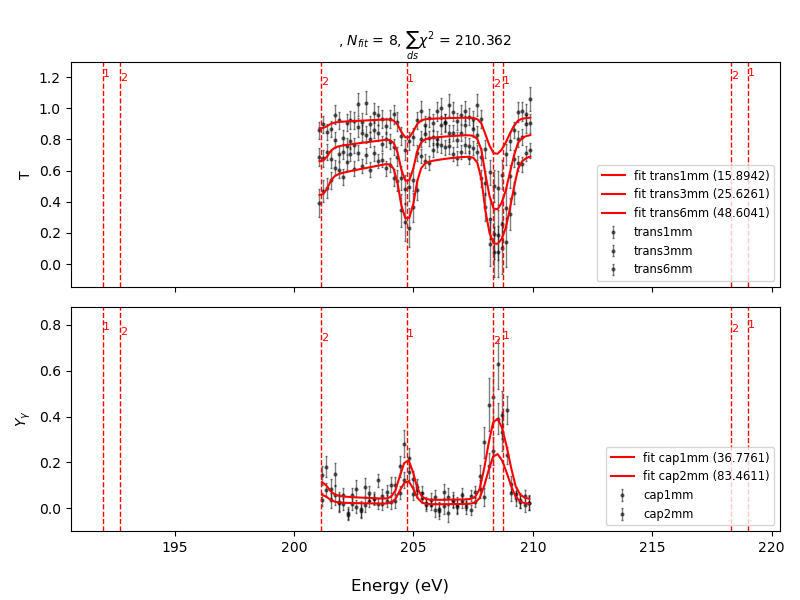

In [78]:

prior = initial_out.sammy_outs_fit_2[-1]

ires = 4
elim_sammyINPyw.resonance_ladder, _ = concat_external_resonance_ladder(history[ires]['ladder'], history[ires]['external'])
rto.bayes=False
post = sammy_functions.run_sammy_YW(elim_sammyINPyw, rto)

fig = plot_datafits(datasets, experiments, 
    # fits=post.pw_post,
    # fit_pars=post.par_post,
    # fits_chi2=post.chi2_post,
    fits=post.pw,
    fit_pars=post.par,
    fits_chi2=post.chi2,

    # priors=post.pw,
    # prior_pars = post.par,
    # priors_chi2= post.chi2
    # priors=prior.pw_post,
    # prior_pars = prior.par_post,
    # priors_chi2= prior.chi2_post
)

fig.tight_layout()

In [99]:

(np.array(chi2)-np.sum(np.array(save), axis=1)) - ObjStart

array([ -9.30604086,  -9.88026932,  42.72683659,  23.97225016,
        -9.62749404,  -8.78908483, -10.20094598,  -9.37849114,
        -9.13464608,  -9.2872588 ,  -9.72889138,  10.04030605,
       -10.40954952,  -9.84299504,  17.94905763, 707.33680722,
       -10.34841552, -10.50187636,  -7.6742066 ,  -7.20940549,
       681.01563645,  52.31397977,  -8.83676634,  -9.53218805,
       133.34801345,  53.01108642,  -9.15062552,  -9.29492724,
        -9.79046529,  -8.92438844,  -8.68452751,  -8.835489  ,
        -9.28016313,  -7.30229504,  -9.84471325,  -9.38156969,
        89.11892575, -10.21649708,  -9.93266957,  -9.92974307,
        -8.68201862,  -8.90518053, -10.13382898,  -4.1373596 ])

(array([37.,  3.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 664.52371391,  700.41564809,  736.30758227,  772.19951645,
         808.09145063,  843.98338481,  879.87531898,  915.76725316,
         951.65918734,  987.55112152, 1023.4430557 , 1059.33498988,
        1095.22692406, 1131.11885824, 1167.01079242, 1202.90272659,
        1238.79466077, 1274.68659495, 1310.57852913, 1346.47046331,
        1382.36239749]),
 <BarContainer object of 20 artists>)

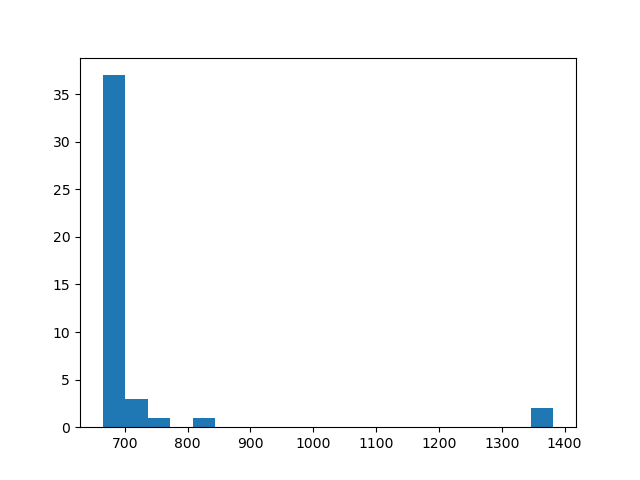

In [76]:
samout_temp.par
figure()
# hist(chi2, bins=20)
hist(np.array(chi2)-np.sum(np.array(save), axis=1), bins=20)

In [55]:
np.max(np.array(save), axis=0)

array([-164.92516946,  -54.9340933 , -190.76757548])

In [56]:
np.min(np.array(save), axis=0)

array([-166.2108793 ,  -54.9340933 , -194.73823501])

In [75]:
np.array(chi2)-np.sum(np.array(save), axis=1)

array([ 665.71954941,  665.14532096,  717.75242686,  698.99784043,
        665.39809623,  666.23650544,  664.8246443 ,  665.64709913,
        665.89094419,  665.73833147,  665.29669889,  685.06589632,
        664.61604076,  665.18259524,  692.97464791, 1382.36239749,
        664.67717475,  664.52371391,  667.35138368,  667.81618478,
       1356.04122672,  727.33957004,  666.18882393,  665.49340223,
        808.37360372,  728.03667669,  665.87496475,  665.73066303,
        665.23512499,  666.10120183,  666.34106276,  666.19010127,
        665.74542714,  667.72329523,  665.18087702,  665.64402058,
        764.14451602,  664.8090932 ,  665.0929207 ,  665.0958472 ,
        666.34357166,  666.12040974,  664.89176129,  670.88823067])

In [65]:
np.min(chi2)

251.1561

In [66]:
np.max(chi2)

971.4625000000001

In [ ]:
minkey = min(history.elimination_history.keys())
maxkey = max(history.elimination_history.keys())
print(minkey)
print(maxkey)
models = [history.elimination_history[i]['selected_ladder_chars'] for i in range(minkey, maxkey+1)]
# models

3
10


Eliminated from 10 res -> 9


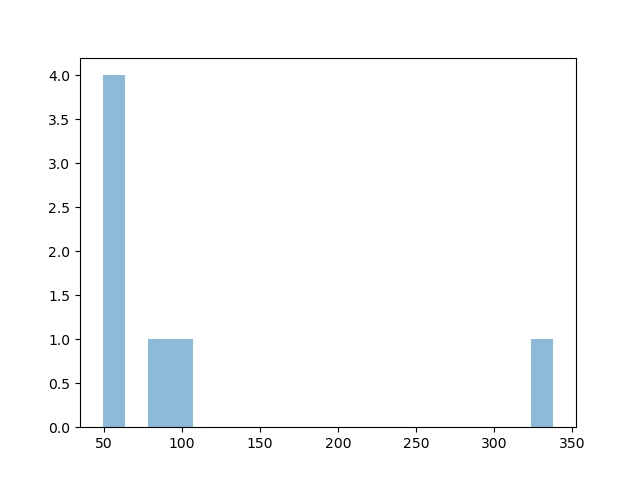

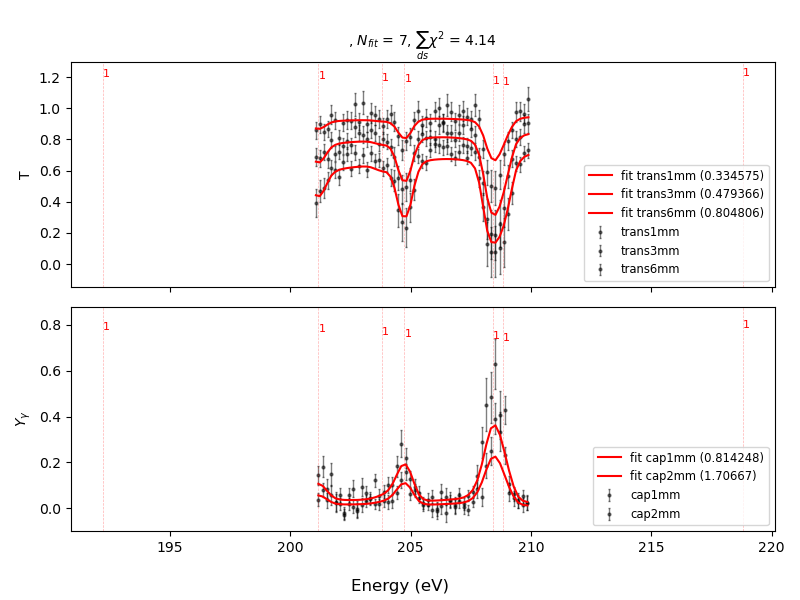

In [ ]:
print(f'Eliminated from {history.ladder_IN.shape[0]} res -> {history.ladder_OUT.shape[0]}')
minkey = min(history.elimination_history.keys())

sammyOUT_elim = history.elimination_history[minkey+5]['selected_ladder_chars']

figure()
# _ = plt.hist(np.log10(sammyOUT_elim.par_post.Gn1), bins=20, label="Gn1")
_= plt.hist(sammyOUT_elim.par_post.Gg, bins=20, label="Gg", alpha=0.5)

fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_elim.pw_post, 
    fits_chi2=sammyOUT_elim.chi2n_post,
    priors=[], priors_chi2=[],
    # true=datasets, 
    true_chi2=[],
    # true_pars = true_ladder, 
    # prior_pars = pd.DataFrame(),
    fit_pars = sammyOUT_elim.par_post,
    # title: str = '',
    show_spingroups = True,
    fig_size = (8,6)
)

fig.tight_layout()

In [ ]:
internal, external = separate_external_resonance_ladder(sammyOUT_elim.par_post, [0,1])
internal

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
2,201.169130,93.132615,0.955245,1.0,0.0,1.0,1.0
3,203.805900,61.295374,0.155817,1.0,0.0,1.0,1.0
4,204.744399,48.983269,2.537562,1.0,0.0,1.0,1.0
5,208.406275,51.037145,5.420118,1.0,0.0,1.0,1.0
6,208.839126,60.789767,2.269770,1.0,0.0,1.0,1.0


In [ ]:
import pickle
from ATARI.AutoFit import spin_group_selection
importlib.reload(spin_group_selection)

spinselectOPT = spin_group_selection.SpinSelectOPT(step_threshold=0.01,
                                                    max_steps=10,
                                                    LevMarV0 = 0.1)
spinselector = spin_group_selection.SpinSelect(spinselectOPT)


all_possible_reslad = spin_group_selection.get_all_resonance_ladder_combinations([1.0, 2.0], jeff_parameters) #internal)




# models = [history.elimination_history[i]['selected_ladder_chars'] for i in range(minkey+1, minkey+3)]

# spinselect_out = spinselector.fit_multiple_models(models,
#                                 [1.0,2.0],
#                                 Ta_pair,
#                                 datasets,
#                                 experiments,
#                                 covariance_data,
#                                 sammy_rto_fit,
#                                 external_resonance_indices)
# ladder = all_possible_reslad[0]
# print(ladder)

# spinselector.try_all_spin_groups( 
#                       [1.0,2.0],
#                       ladder,
#                       Ta_pair,
#                       datasets,
#                       experiments,
#                       covariance_data,
#                       sammy_rto_fit,
#                       external_resonance_indices=[])

In [ ]:
# for each in all_possible_reslad:
print(len(jeff_parameters))
print(len(all_possible_reslad))

2
4


In [ ]:
print(2**5)
print(2**12)

32
4096


Text(0.5, 1.0, 'Likelihood (over all 3 parameters) for all possible spin combinations\n Ladder: JEFF 3.3 190-260 eV')

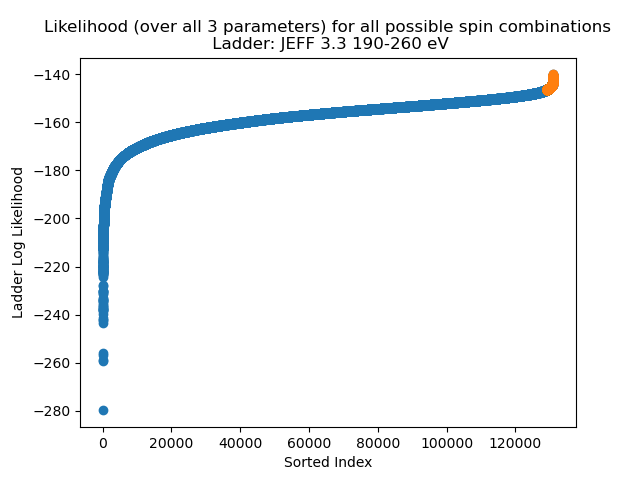

In [ ]:
figure()
scatter(range(len(all_possible_reslad)), LLs[sort_index])
scatter(range(len(all_possible_reslad))[-max_num:], LLs[indices_to_evaluate])
ylabel("Ladder Log Likelihood")
xlabel("Sorted Index")
title("Likelihood (over all 3 parameters) for all possible spin combinations\n Ladder: JEFF 3.3 190-260 eV")


In [ ]:
from ATARI.AutoFit.control import AutoFitOUT

autofit_out = AutoFitOUT(initial_out, history, spinselect_out)

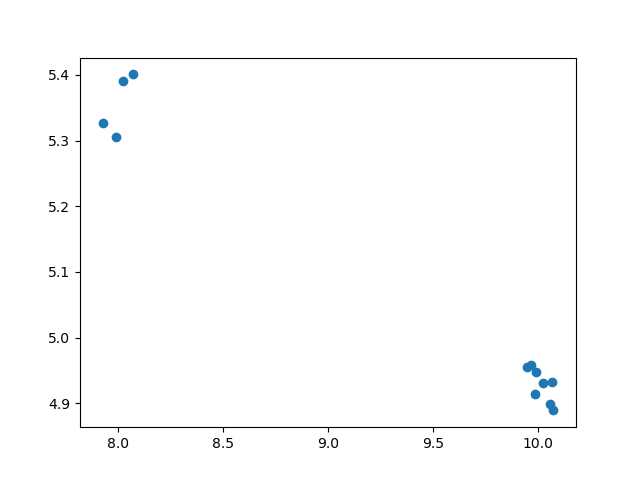

In [ ]:
# all_chi2n = [np.sum(each.chi2n_post) for each in spinselectOUT.all_sammy_outs]
x = []
y = []
for key, val in spinselect_out.history.items():
    x.extend([float(key)]*len(val['all_chi2n']) )
    y.extend(val['all_chi2n'])


x = np.array(x) + x + np.random.default_rng().uniform(-0.1,0.1, size=len(x))
figure()
scatter(x, y)


# _ = hist(all_chi2n, bins=100, density=False)
# scatter(range(len(all_chi2n)), all_chi2n)
# axhline(np.sum(spinselectOUT.leading_model.chi2n_post), color='r')

In [ ]:
print(sammyOUT_elim.chi2n_post, np.sum(sammyOUT_elim.chi2n_post))
print(sammyOUT_spin.chi2n_post, np.sum(sammyOUT_spin.chi2n_post))
print(sammyOUT_elim.par_post)
print(sammyOUT_spin.par_post)
fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_spin.pw_post, 
    fits_chi2=sammyOUT_spin.chi2n_post,
    priors=[], priors_chi2=[],
    # true=sammyOUT.pw_post, 
    # true_chi2= sammyOUT.chi2n_post,
    # true_pars = sammyOUT.par_post, 
    prior_pars = sammyOUT_elim.par_post,
    fit_pars = sammyOUT_spin.par_post,
    # title: str = '',
    show_spingroups = True,
    fig_size = (8,6)
)

fig.tight_layout()

[0.779351, 1.80442, 0.599216, 0.869041, 1.71593] 5.767958


NameError: name 'sammyOUT_spin' is not defined

### Next steps

Before giving this to oleksii for AIC, I could fit background with external resonances
1. fix the result above
2. add external resonances on either side of the window with fixed energies
3. Fit external resonance widths to capture background
4. give results to Oleksii where AIC will eliminate and re-fit all internal resonance parameters and only widths of external resonances


In [ ]:
import pickle

# open a file, where you ant to store the data
file = open('./initialFB.pkl', 'wb')
pickle.dump(start_ladder, file)
file.close()

for i in range(9,13):
    obj = history.elimination_history[i]['selected_ladder_chars']
    file = open(f'./elim_{i}.pkl', 'wb')
    pickle.dump(obj, file)
    file.close()
    
# for i in range(9,12):
#     obj = history.elimination_history[i]['selected_ladder_chars']
# # file = open('./spin_group.pkl', 'wb')
# # pickle.dump(start_ladder, file)
# # file.close()

In [ ]:
file = open('./spin_model_12.pkl', 'rb')
fbout = pickle.load(file)
file.close()

In [ ]:
fbout.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,204.741872,54.075581,2.348920,1.0,0.0,1.0,2.0
1,208.522334,57.442773,8.921431,1.0,0.0,1.0,2.0
2,214.831151,3.060050,10.774297,1.0,0.0,1.0,1.0
3,215.294030,78.994529,21.835185,1.0,0.0,1.0,1.0
4,216.627523,103.291985,17.032382,1.0,0.0,1.0,1.0
5,219.761676,32.482910,7.020997,1.0,0.0,1.0,1.0
6,219.971992,70.570667,6.961697,1.0,0.0,1.0,1.0
7,222.304332,61.647417,2.630040,1.0,0.0,1.0,2.0
8,225.208830,78.575612,23.435459,1.0,0.0,1.0,1.0
9,200.000000,64.998137,67.145788,0.0,1.0,1.0,1.0
